In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import re
from datetime import datetime
import seaborn as sns
from scipy import stats 

# Some helper functions

In [2]:
def time_difference_in_minutes(time_str1, time_str2):
    try:
        time_format = "%H:%M:%S"
        time1 = datetime.strptime(time_str1, time_format)
        time2 = datetime.strptime(time_str2, time_format)
        time_difference = time1 - time2
        minutes_difference = time_difference.total_seconds() / 60
        return minutes_difference
    except:
        # Handle invalid time string format
        return None
    
def date_to_day_of_week(date_str):
    try:
        # Parse the date string into a datetime object
        date = datetime.strptime(date_str, "%m/%d/%y")
        
        # Get the day of the week as a string (e.g., 'Monday')
        day_of_week = date.strftime('%A')
        
        return day_of_week
    except:
        return "Invalid date format"
    

def make_cor_plot_single(x_values, y_values, x_label="X Label", y_label="Y Label", title="Title"):
    m, b = np.polyfit(x_values, y_values, 1)
    plt.scatter(x_values, y_values)
    
    # Change the color of the regression line to red
    plt.plot(x_values, m*x_values+b, color='red')
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    
    text_content = f"y= {m:.2f}x + {b:.2f}"
    
    # Add a border to the text box
    bbox_props = dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', lw=1)
    
    textbox_x = min(x_values)  # X-coordinate for the top-left corner
    textbox_y = max(y_values)  # Y-coordinate for the top-left corner (use the maximum y-value)
    
    # Add the text box with border
    plt.text(textbox_x, textbox_y, text_content, fontsize=12, color='red', bbox=bbox_props)
    
    plt.legend()  # Show legend for the regression line
    plt.show()


# Data Processing
 - Add a day_name column
- Create a dataframe called data_complete_trips that onlly contains completed trips

### Add a day_name column and a time_periods column

In [3]:
###########CREATE DAY NAME#######################
data = pd.read_csv('../data/data.csv')
data["day_name"] = data["DATE"].apply(date_to_day_of_week)


######CREATE TIME PERIODS########
df = data.copy()
# Define time periods
time_periods = {
    (3, 6): 'early Morn',
    (6, 9): 'Morn rush',
    (9, 12): 'Morn',
    (12, 16): 'Aft',
    (16, 18): 'Eve rush',
    (18, 22): 'Eve',
    (22, 26): 'Night'
}
time_period_list = list(time_periods.values())
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
# Function to categorize time periods based on hour
def categorize_time_period(time_str):
    hr =int(time_str.split(":")[0])
    for period_range, period_label in time_periods.items():
        if period_range[0] <= hr < period_range[1]:
            return period_label
    return "INVALID TIME"

# Add a new column "time_periods"
df['time_periods'] = df['SCHEDULED_TIME'].apply(categorize_time_period)
data = df


In [4]:
data_complete_trips = pd.read_csv('../data/data_complete_trips.csv')

#Marks all trips which are complete (start with 1 and end with 2) as Complete_trip = True 
# df = data.copy()
# df["Complete_trip"] = False
# trip_started = False
# for index, row in df.iterrows():
#     trip_edge = row["TRIP_EDGE"]
#     if trip_edge == 1:
#         trip_started = True
#         df.loc[index, "Complete_trip"] = True
#     if trip_edge == 0 and trip_started:
#       df.loc[index, "Complete_trip"] = True
#     if trip_edge == 2 and trip_started:
#       trip_started = False
#       df.loc[index, "Complete_trip"] = True      
# data = df

# # Get all the complete trips
# data_complete_trips = data[data["Complete_trip"]==True]

# # remove trips for which all trip edges don't have the same trip ID (there are only 4 such trips)
# trip_start_indexes = data_complete_trips[data_complete_trips['TRIP_EDGE'] == 1].index.to_list()
# trip_end_indexes = data_complete_trips[data_complete_trips['TRIP_EDGE'] == 2].index.to_list()
# not_same_tripids = []
# for one, two in zip(trip_start_indexes, trip_end_indexes):
#     if len(set(data_complete_trips.loc[one:two]["TRIP_ID"].tolist())) >1:
#         not_same_tripids.append([one, two])
# u = data_complete_trips.copy()
# u["SAME_TRIP_IDs"] = True
# for start, end in not_same_tripids:
#     u.loc[start:end, 'SAME_TRIP_IDs'] = False
# data_complete_trips = u[u['SAME_TRIP_IDs'] == True]
# data_complete_trips = data_complete_trips.drop(columns=["SAME_TRIP_IDs", "Complete_trip"])
# data_complete_trips.to_csv('../data/data_complete_trips.csv')

In [5]:
data_complete_trips["TRIP_EDGE"].value_counts()

TRIP_EDGE
0    213869
1     67411
2     67411
Name: count, dtype: int64

# Adherence and Headway Deviation

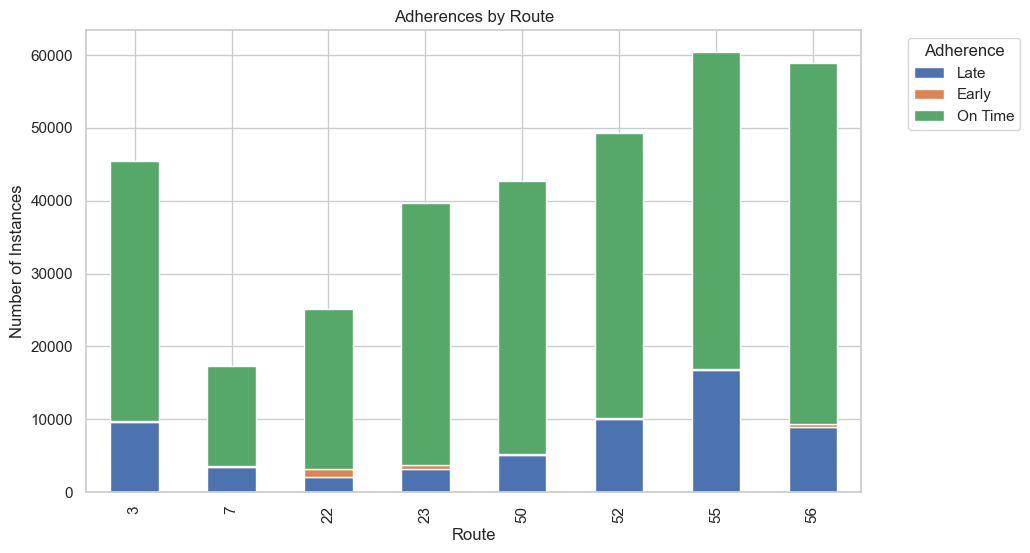

In [40]:
df= data.copy()
# Remove rows with null values in the "ADHERENCE" column
df = df.dropna(subset=["ADHERENCE"])
#df[(df["ROUTE_ABBR"]==3) & (df["ADHERENCE"])>=0]
df["Late"] = df["ADHERENCE"]<=-6
df["Early"] = df["ADHERENCE"]>=6
df["On Time"] = abs(df["ADHERENCE"])<6

# Group by ROUTE_ABBR and sum the Late and Early values
grouped_data = df.groupby('ROUTE_ABBR')[['Late', 'Early', "On Time"]].sum()

# Plotting the stacked bar plot
ax = grouped_data.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Adherences by Route')
plt.xlabel('Route')
plt.ylabel('Number of Instances')
plt.legend(title='Adherence', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



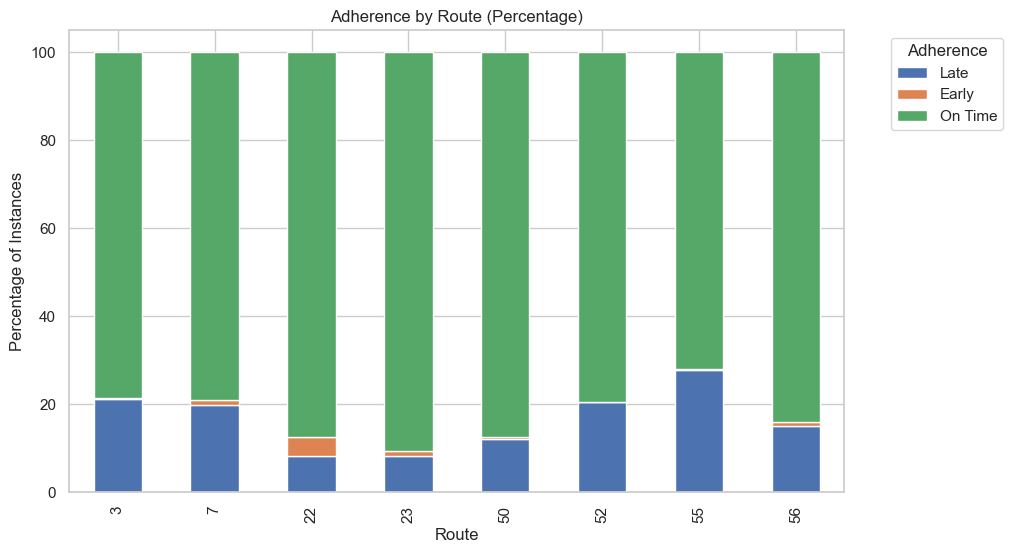

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
df = data.copy()
df = df.dropna(subset=["ADHERENCE"])

# Creating categorical columns for Late, Early, and On Time
df["Late"] = df["ADHERENCE"] <= -6
df["Early"] = df["ADHERENCE"] >= 6
df["On Time"] = abs(df["ADHERENCE"]) < 6

# Group by ROUTE_ABBR and calculate percentages of Late, Early, and On Time
grouped_data = df.groupby('ROUTE_ABBR')[['Late', 'Early', 'On Time']].mean() * 100

# Plotting the stacked bar plot with percentages
ax = grouped_data.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Adherence by Route (Percentage)')
plt.xlabel('Route')
plt.ylabel('Percentage of Instances')
plt.legend(title='Adherence', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [57]:
grouped_data.reset_index().sort_values(by="Late")

,ROUTE_ABBR,Late,Early,On Time
3,23,8.198623,1.180239,90.621138
2,22,8.250288,4.224401,87.525311
4,50,12.066903,0.382369,87.550728
7,56,15.078880,0.919423,84.001696
1,7,19.864481,1.181444,78.954074
5,52,20.398565,0.218947,79.382488
0,3,21.196799,0.318765,78.484435
6,55,27.821866,0.233602,71.944532


## Adherence by day of the week

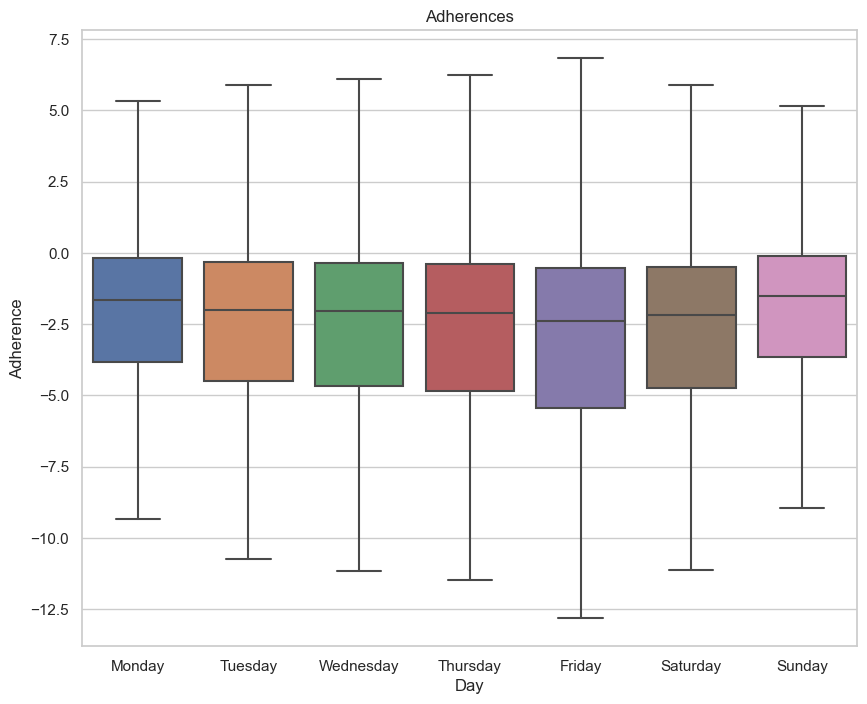

In [8]:
df= data.copy()
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))

# Remove rows with null values in the "ADHERENCE" column
df_filtered = df.dropna(subset=["ADHERENCE"])

# Create the box plot
sns.boxplot(x="day_name", y="ADHERENCE", data=df_filtered, showfliers=False, order=day_order)

# Set labels and title
plt.xlabel("Day")
plt.ylabel("Adherence")
plt.title("Adherences")

# Show the plot
plt.show()

## Adherence by day of the week, split up by routes

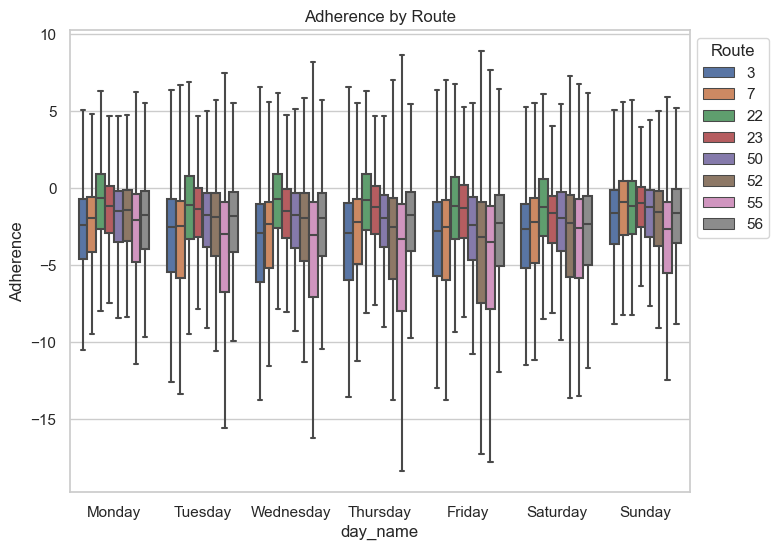

In [9]:
df= data.copy()
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Remove rows with null values in the "ADHERENCE" column
df_filtered = df.dropna(subset=["ADHERENCE"])

# Set the order of days:
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Create the box plot
ax = sns.boxplot(x="day_name", y="ADHERENCE", data=df_filtered, hue="ROUTE_ABBR", showfliers=False, order=day_order)

# Set labels and title
# plt.xlabel("Day of the Week")
plt.ylabel("Adherence")
plt.title("Adherence by Route")

ax.legend(title="Route", loc="upper left", bbox_to_anchor=(1, 1))

# Show the plot
plt.show()

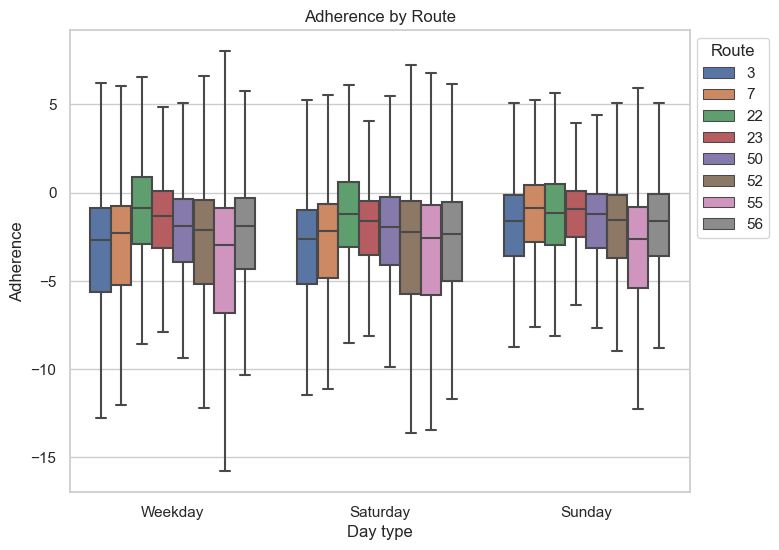

In [10]:
df= data.copy()
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Remove rows with null values in the "ADHERENCE" column
df_filtered = df.dropna(subset=["ADHERENCE"])
df_filtered = df_filtered.copy()
df_filtered["SERVICE_ABBR"] = df_filtered["SERVICE_ABBR"].map({
    1: 'Weekday',
    2: 'Saturday',
    3: 'Sunday'
})


# Create the box plot
ax = sns.boxplot(x="SERVICE_ABBR", y="ADHERENCE", data=df_filtered, hue="ROUTE_ABBR", showfliers=False)

# Set labels and title
plt.xlabel("Day type")
plt.ylabel("Adherence")
plt.title("Adherence by Route")

ax.legend(title="Route", loc="upper left", bbox_to_anchor=(1, 1))

# Show the plot
plt.show()

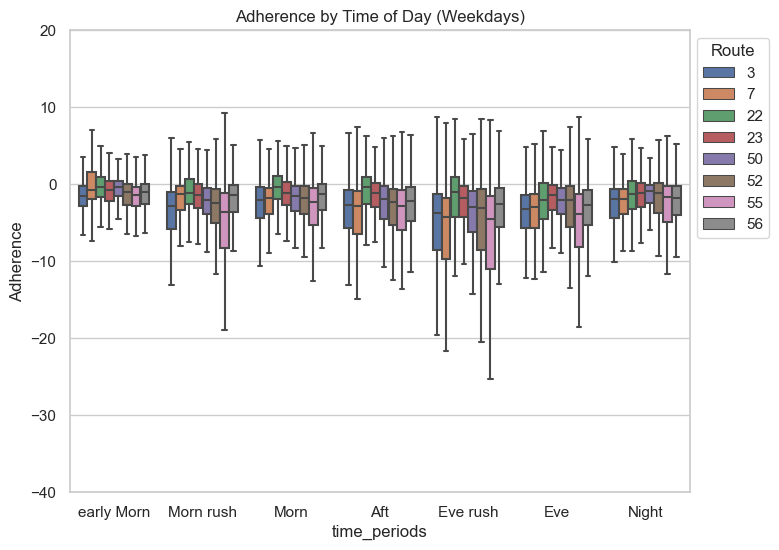

In [11]:
df= data.copy()
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Remove rows with null values in the "ADHERENCE" column
df_filtered = df.dropna(subset=["ADHERENCE"])
df_filtered = df_filtered[df_filtered["SERVICE_ABBR"]==1]



# Create the box plot
ax = sns.boxplot(x="time_periods", y="ADHERENCE", data=df_filtered, hue="ROUTE_ABBR", showfliers=False, order=time_period_list)

# Set labels and title
# plt.xlabel("Day of the Week")
plt.ylabel("Adherence")
plt.title("Adherence by Time of Day (Weekdays)")

# Set the y-axis limit
ax.set_ylim(-40, 20)

ax.legend(title="Route", loc="upper left", bbox_to_anchor=(1, 1))

# Show the plot
plt.show()

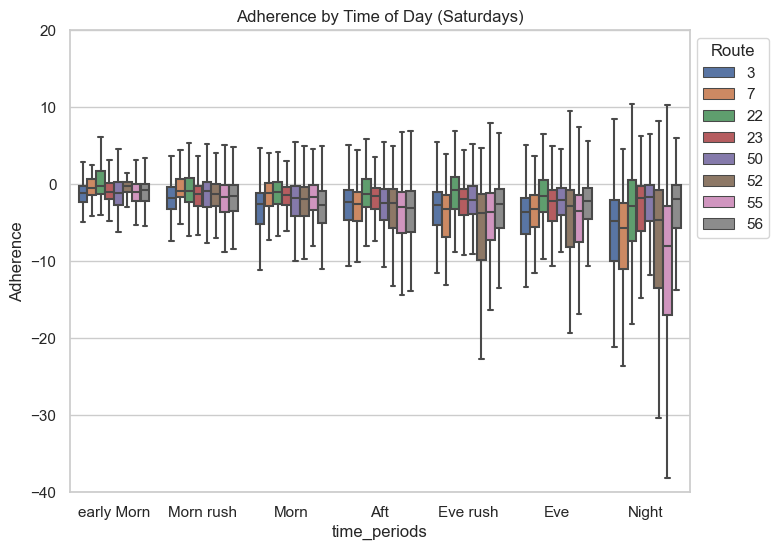

In [12]:
df= data.copy()
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Remove rows with null values in the "ADHERENCE" column
df_filtered = df.dropna(subset=["ADHERENCE"])
df_filtered = df_filtered[df_filtered["SERVICE_ABBR"]==2]



# Create the box plot
ax = sns.boxplot(x="time_periods", y="ADHERENCE", data=df_filtered, hue="ROUTE_ABBR", showfliers=False, order=time_period_list)

# Set labels and title
# plt.xlabel("Day of the Week")
plt.ylabel("Adherence")
plt.title("Adherence by Time of Day (Saturdays)")

# Set the y-axis limit
ax.set_ylim(-40, 20)

ax.legend(title="Route", loc="upper left", bbox_to_anchor=(1, 1))

# Show the plot
plt.show()

In [13]:
time_period_list

['early Morn', 'Morn rush', 'Morn', 'Aft', 'Eve rush', 'Eve', 'Night']

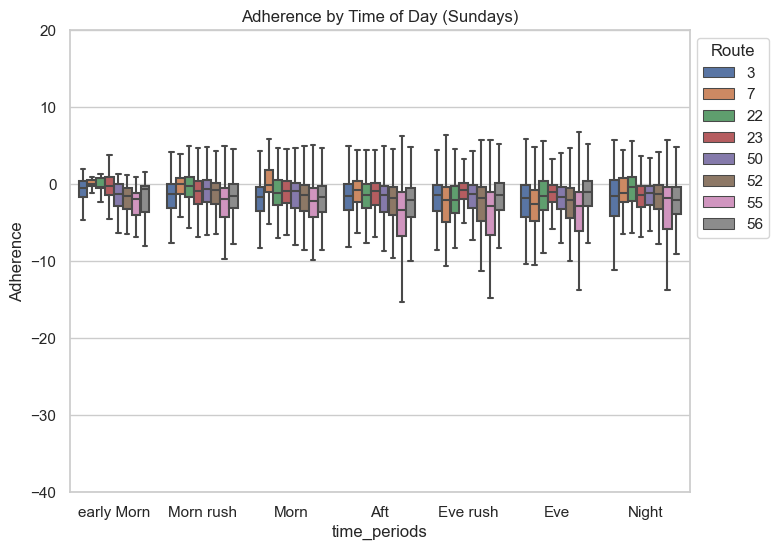

In [14]:
df= data.copy()
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Remove rows with null values in the "ADHERENCE" column
df_filtered = df.dropna(subset=["ADHERENCE"])
df_filtered = df_filtered[df_filtered["SERVICE_ABBR"]==3]



# Create the box plot
ax = sns.boxplot(x="time_periods", y="ADHERENCE", data=df_filtered, hue="ROUTE_ABBR", showfliers=False, order=time_period_list)

# Set labels and title
# plt.xlabel("Day of the Week")
plt.ylabel("Adherence")
plt.title("Adherence by Time of Day (Sundays)")

# Set the y-axis limit
ax.set_ylim(-40, 20)

ax.legend(title="Route", loc="upper left", bbox_to_anchor=(1, 1))

# Show the plot
plt.show()

## Adherence by direction of travel

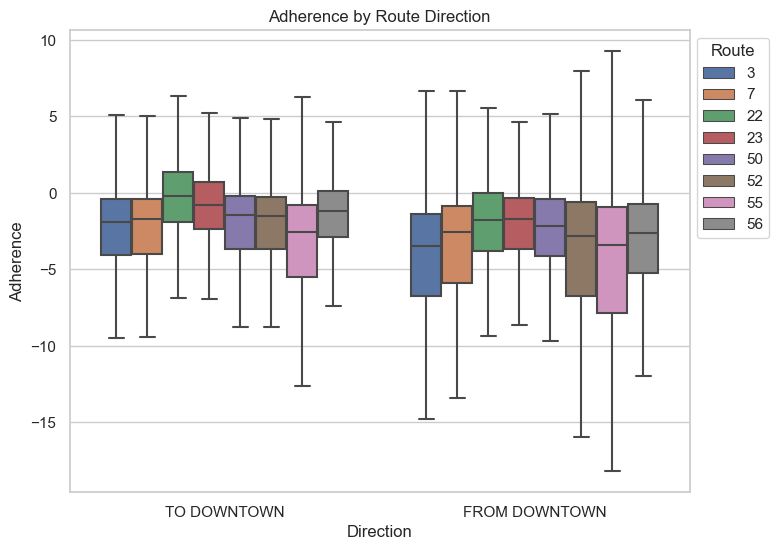

In [15]:
df= data.copy()
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Remove rows with null values in the "ADHERENCE" column
df_filtered = df.dropna(subset=["ADHERENCE"])

# Create the box plot
ax = sns.boxplot(x="ROUTE_DIRECTION_NAME", y="ADHERENCE", hue="ROUTE_ABBR", data=df_filtered, showfliers=False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# Set labels and title
plt.xlabel("Direction")
plt.ylabel("Adherence")
plt.title("Adherence by Route Direction")

ax.legend(title="Route", loc="upper left", bbox_to_anchor=(1, 1))
# Show the plot
plt.show()

# Headway Deviations

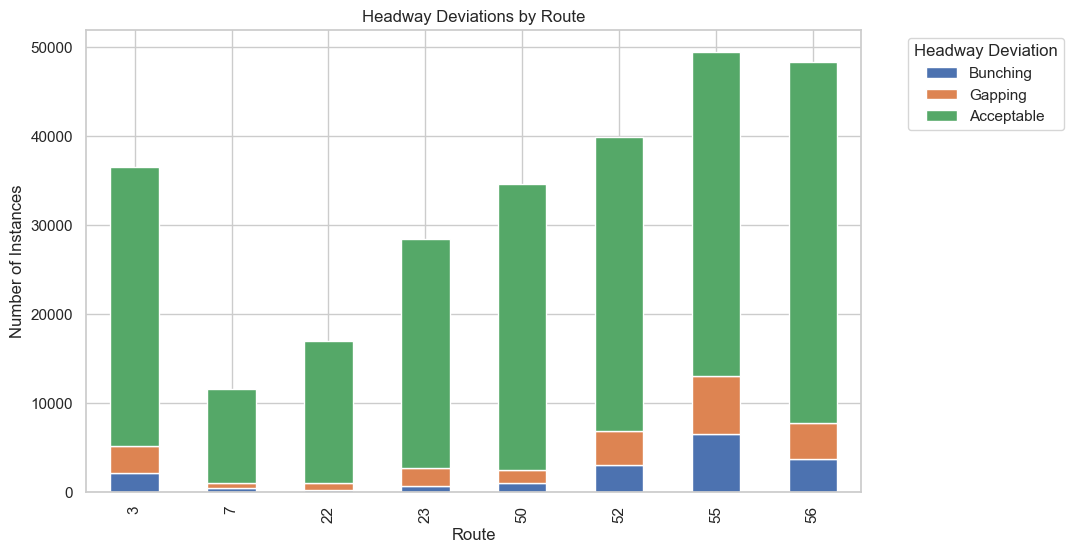

In [37]:
df= data.copy()
# Remove rows with null values in the "ADHERENCE" column
df = df.dropna(subset=["HDWY_DEV", "SCHEDULED_HDWY"])
df["Bunching"] = df["HDWY_DEV"]<=-df["SCHEDULED_HDWY"]*0.5
df["Gapping"] = df["HDWY_DEV"]>=df["SCHEDULED_HDWY"]*0.5
df["Acceptable"] = abs(df["HDWY_DEV"])<df["SCHEDULED_HDWY"]*0.5

# Group by ROUTE_ABBR and sum the Late and Early values
grouped_data = df.groupby('ROUTE_ABBR')[['Bunching', 'Gapping', 'Acceptable']].sum()

# Plotting the stacked bar plot
ax = grouped_data.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Headway Deviations by Route')
plt.xlabel('Route')
plt.ylabel('Number of Instances')
plt.legend(title='Headway Deviation', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

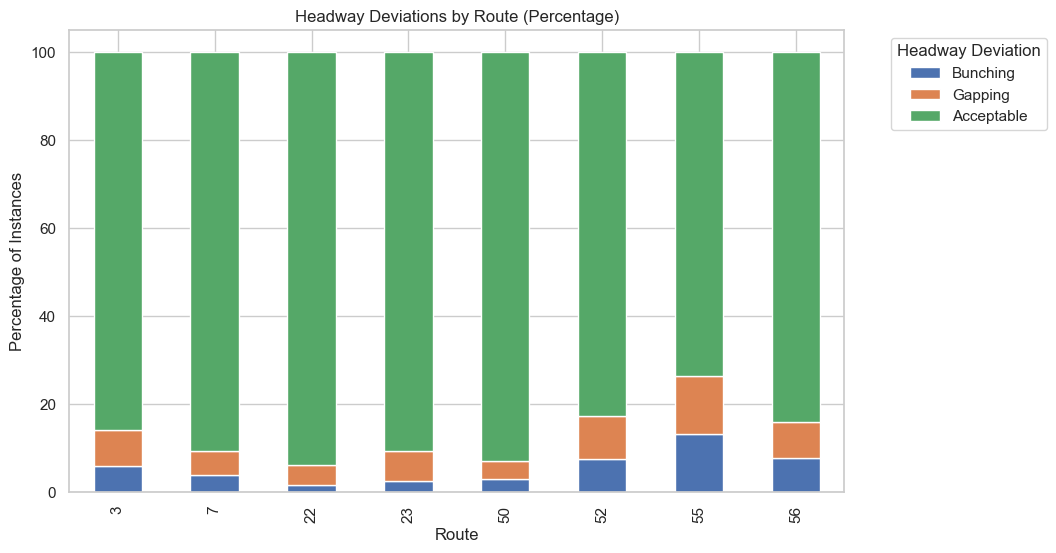

In [50]:
df = data.copy()
df = df.dropna(subset=["HDWY_DEV", "SCHEDULED_HDWY"])
df["Bunching"] = df["HDWY_DEV"] <= -df["SCHEDULED_HDWY"] * 0.5
df["Gapping"] = df["HDWY_DEV"] >= df["SCHEDULED_HDWY"] * 0.5
df["Acceptable"] = abs(df["HDWY_DEV"]) < df["SCHEDULED_HDWY"] * 0.5

# Group by ROUTE_ABBR and calculate percentages of Bunching, Gapping, and As Scheduled
grouped_data = df.groupby('ROUTE_ABBR')[['Bunching', 'Gapping', 'Acceptable']].mean() * 100

# Plotting the stacked bar plot with percentages
ax = grouped_data.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Headway Deviations by Route (Percentage)')
plt.xlabel('Route')
plt.ylabel('Percentage of Instances')
plt.legend(title='Headway Deviation', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [54]:
grouped_data.reset_index().sort_values(by ="Bunching")

,ROUTE_ABBR,Bunching,Gapping,Acceptable
2,22,1.746442,4.357286,93.896272
3,23,2.598497,6.847391,90.554112
4,50,3.072876,4.084641,92.842483
1,7,4.016238,5.337709,90.646053
0,3,5.983654,8.072055,85.944291
5,52,7.586432,9.637225,82.776343
7,56,7.700424,8.331437,83.974346
6,55,13.351675,13.177699,73.470626


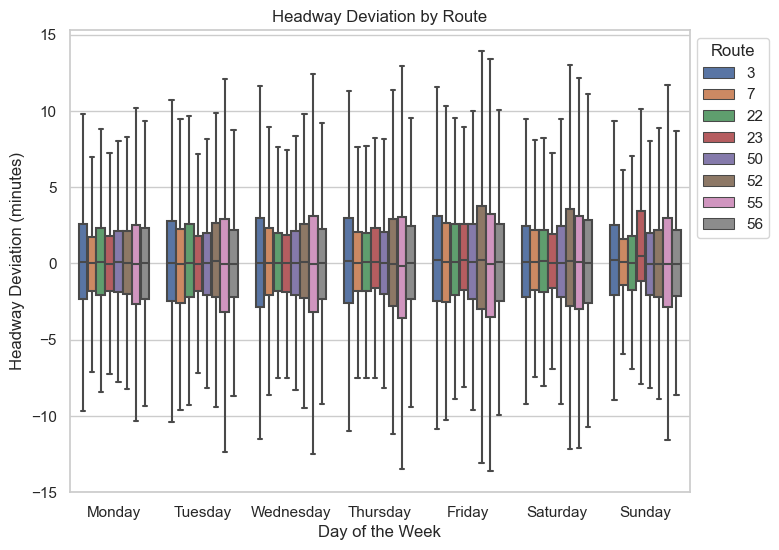

In [17]:
df= data.copy()
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Remove rows with null values in the "HDWY_DEV" column
df_filtered = df.dropna(subset=["HDWY_DEV"])



# Create the box plot
ax = sns.boxplot(x="day_name", y="HDWY_DEV", data=df_filtered, hue="ROUTE_ABBR", showfliers=False, order=day_order)

# Set labels and title
plt.xlabel("Day of the Week")
plt.ylabel("Headway Deviation (minutes)")
plt.title("Headway Deviation by Route")

ax.legend(title="Route", loc="upper left", bbox_to_anchor=(1, 1))

# Show the plot
plt.show()

## Headway deviations by direction of travel

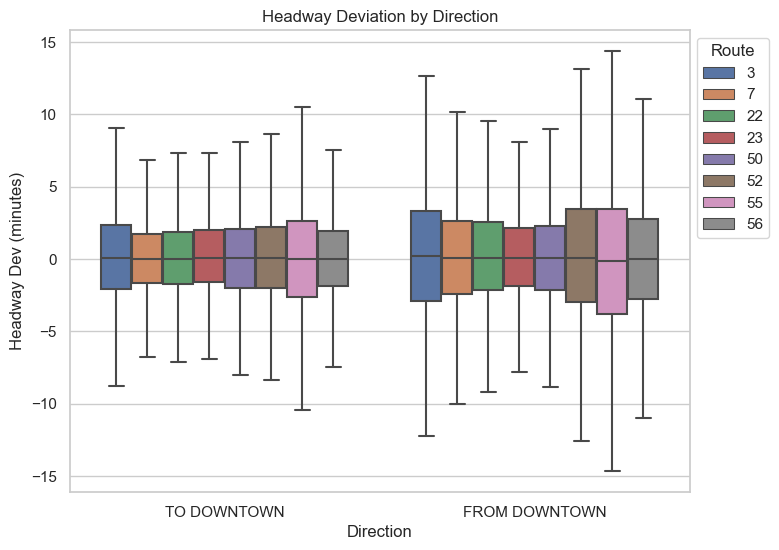

In [18]:
df= data.copy()
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Remove rows with null values in the "HDWY_DEV" column
df_filtered = df.dropna(subset=["HDWY_DEV"])

# Create the box plot
ax = sns.boxplot(x="ROUTE_DIRECTION_NAME", y="HDWY_DEV", hue="ROUTE_ABBR", data=df_filtered, showfliers=False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# Set labels and title
plt.xlabel("Direction")
plt.ylabel("Headway Dev (minutes)")
plt.title("Headway Deviation by Direction")

ax.legend(title="Route", loc="upper left", bbox_to_anchor=(1, 1))
# Show the plot
plt.show()

Headway deviations with time of day

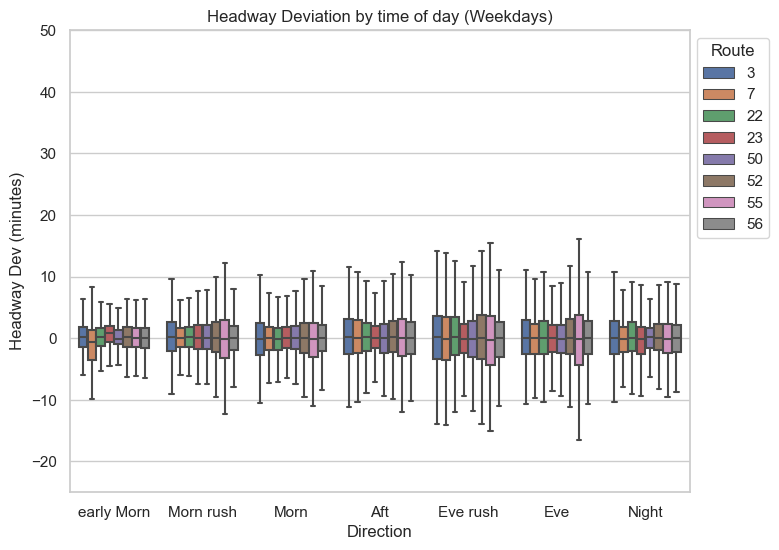

In [19]:
df= data.copy()
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Remove rows with null values in the "HDWY_DEV" column
df_filtered = df.dropna(subset=["HDWY_DEV"])
df_filtered = df_filtered[df_filtered["SERVICE_ABBR"]==1]

# Create the box plot
ax = sns.boxplot(x="time_periods", y="HDWY_DEV", hue="ROUTE_ABBR", data=df_filtered, showfliers=False, order=time_period_list)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# Set labels and title
plt.xlabel("Direction")
plt.ylabel("Headway Dev (minutes)")
plt.title("Headway Deviation by time of day (Weekdays)")

# Set the y-axis limit
ax.set_ylim(-25, 50)

ax.legend(title="Route", loc="upper left", bbox_to_anchor=(1, 1))
# Show the plot
plt.show()

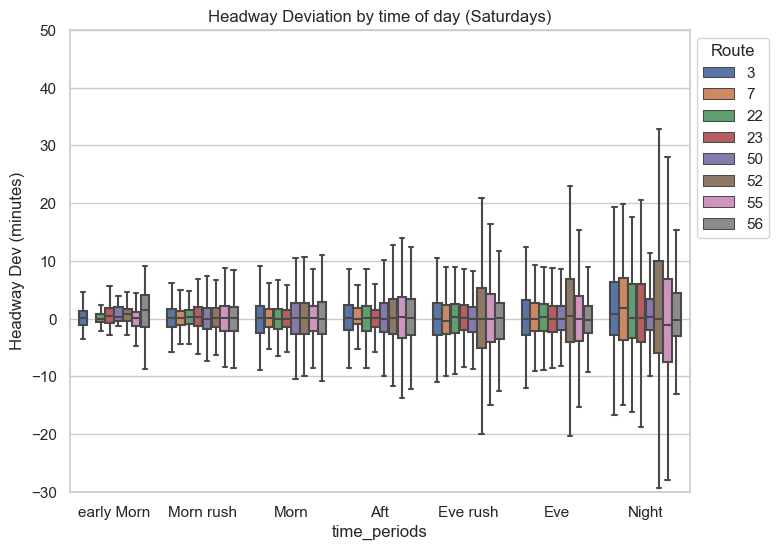

In [20]:
df= data.copy()
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Remove rows with null values in the "HDWY_DEV" column
df_filtered = df.dropna(subset=["HDWY_DEV"])
df_filtered = df_filtered[df_filtered["SERVICE_ABBR"]==2]

# Create the box plot
ax = sns.boxplot(x="time_periods", y="HDWY_DEV", hue="ROUTE_ABBR", data=df_filtered, showfliers=False, order=time_period_list)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# Set labels and title
# plt.xlabel("Direction")
plt.ylabel("Headway Dev (minutes)")
plt.title("Headway Deviation by time of day (Saturdays)")

# Set the y-axis limit
ax.set_ylim(-30, 50)

ax.legend(title="Route", loc="upper left", bbox_to_anchor=(1, 1))
# Show the plot
plt.show()

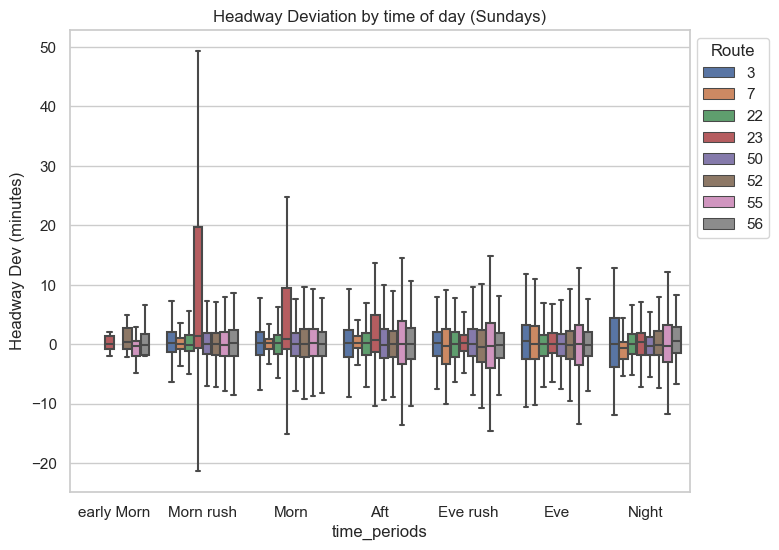

In [21]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Remove rows with null values in the "HDWY_DEV" column
df_filtered = df.dropna(subset=["HDWY_DEV"])
df_filtered = df_filtered[df_filtered["SERVICE_ABBR"]==3]

# Create the box plot
ax = sns.boxplot(x="time_periods", y="HDWY_DEV", hue="ROUTE_ABBR", data=df_filtered, showfliers=False, order=time_period_list)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# Set labels and title
# plt.xlabel("Direction")
plt.ylabel("Headway Dev (minutes)")
plt.title("Headway Deviation by time of day (Sundays)")

ax.legend(title="Route", loc="upper left", bbox_to_anchor=(1, 1))
# Show the plot
plt.show()

## Starting vs Ending Adherences
- We plot the start Adherence and End Adherence for each trip
- Since the data includes a lot of outliers we restrict each axis to a maximum of the 3 standard deviations of the mean 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


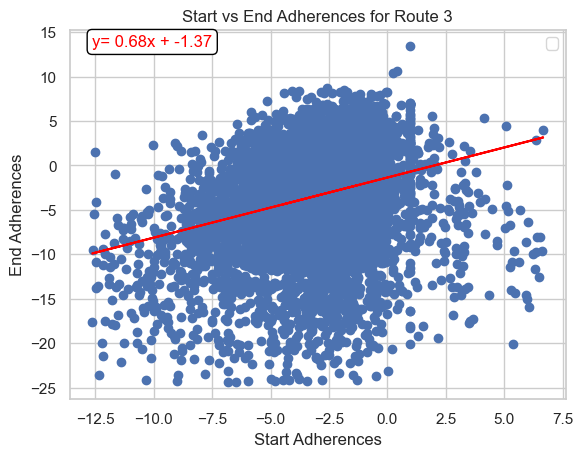

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


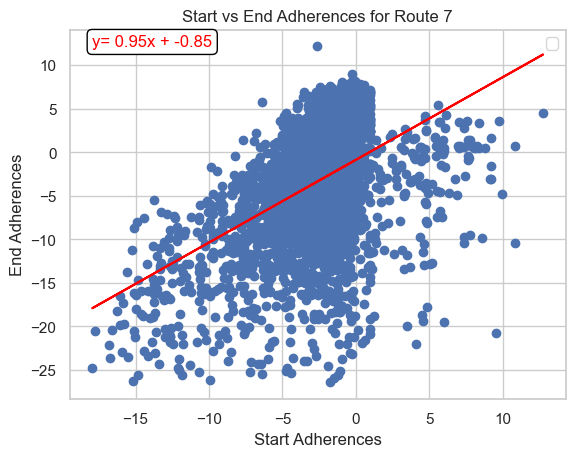

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


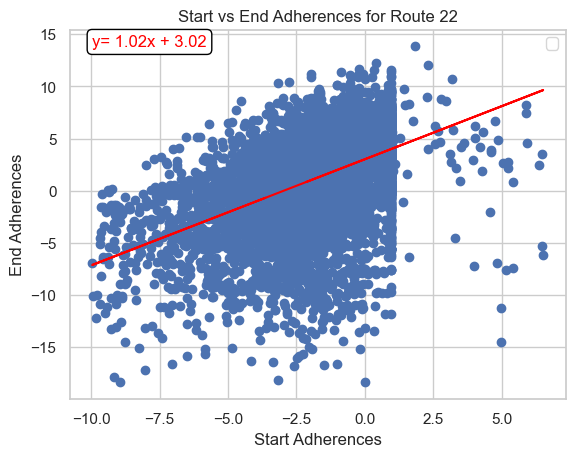

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


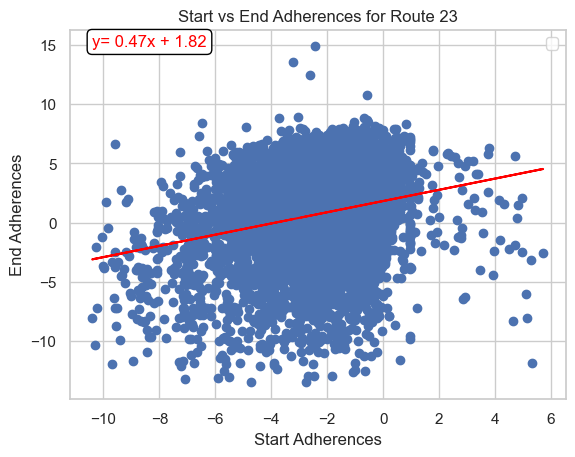

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


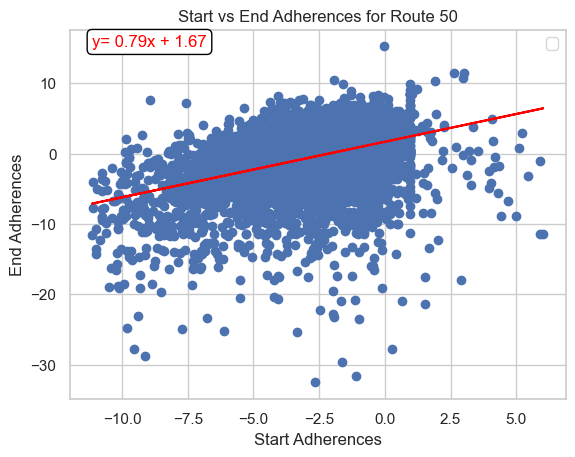

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


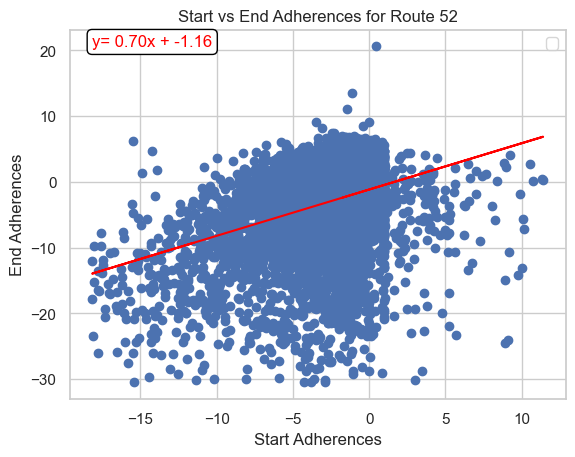

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


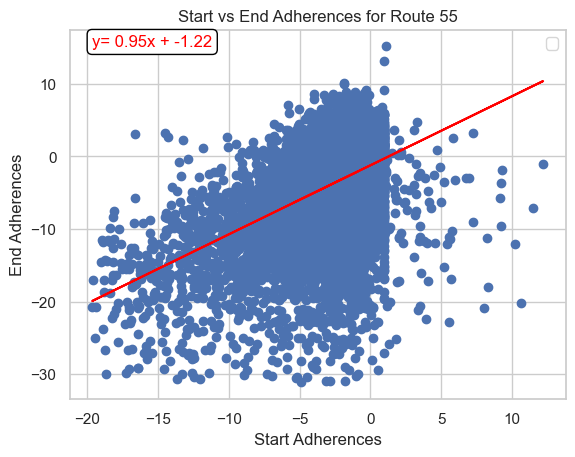

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


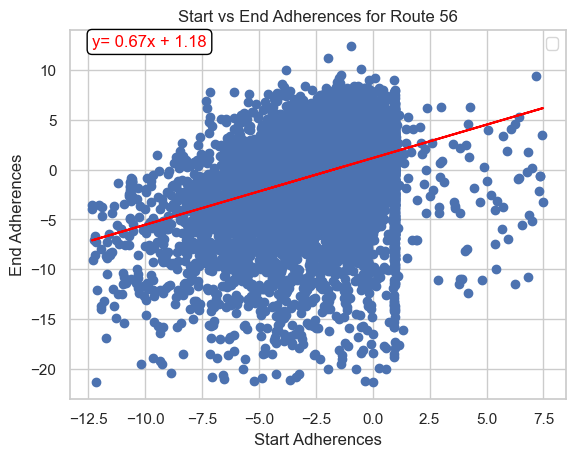

In [22]:
def make_adherence_plot(route):
    df = data_complete_trips
    df = df[df["ROUTE_ABBR"] == route]
    start_adherences = df[(df["TRIP_EDGE"] ==1)]["ADHERENCE"]
    end_adherences = df[df["TRIP_EDGE"] ==2]["ADHERENCE"]
    adherences = pd.DataFrame({
        "Start": start_adherences.values,
        "End": end_adherences.values
    })
    adherences = adherences.dropna()
    adherences.shape
    xvar = adherences["Start"]
    yvar = adherences["End"]
    num_std = 3
    xmin = np.mean(xvar) - num_std*np.std(xvar)
    xmax = np.mean(xvar) + num_std*np.std(xvar)
    ymin = np.mean(yvar) - num_std*np.std(yvar)
    ymax = np.mean(yvar) + num_std*np.std(yvar)
    adherences = adherences.loc[(adherences["Start"] >= xmin) & (adherences["Start"] <= xmax)].loc[(adherences["End"] >= ymin) & (adherences["End"] <= ymax)]
    xvar = adherences["Start"]
    yvar = adherences["End"]

    make_cor_plot_single(xvar, yvar, "Start Adherences", "End Adherences", f"Start vs End Adherences for Route {route}")

routes = [3, 7, 22, 23, 50, 52, 55, 56] 
for route in routes:
    make_adherence_plot(route)




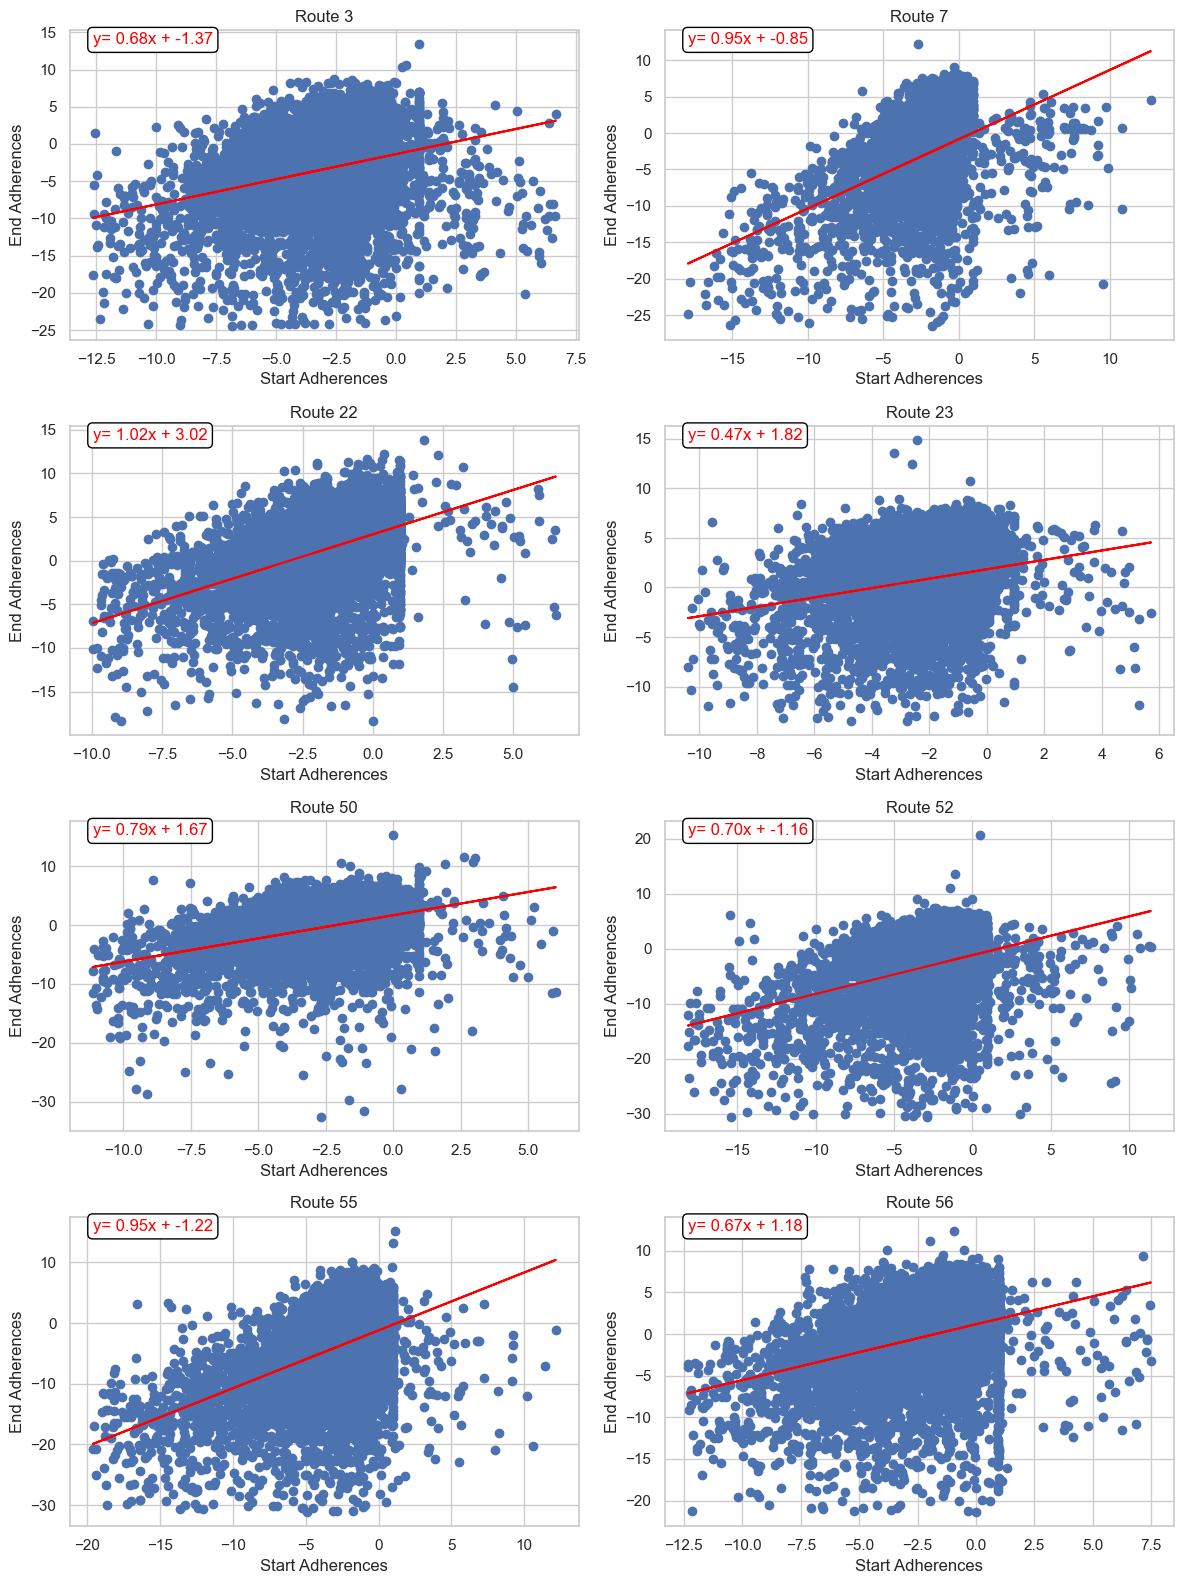

In [23]:
def make_cor_plot_multiple(ax, x_values, y_values, x_label="X Label", y_label="Y Label", title="Title"):
    m, b = np.polyfit(x_values, y_values, 1)
    ax.scatter(x_values, y_values)
    
    # Change the color of the regression line to red
    ax.plot(x_values, m*x_values+b, color='red')
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    
    text_content = f"y= {m:.2f}x + {b:.2f}"
    
    # Add a border to the text box
    bbox_props = dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', lw=1)
    
    # Adjust the coordinates for the top left corner
    textbox_x = np.min(x_values) - 0 * (np.max(x_values) - np.min(x_values))
    textbox_y = np.max(y_values)
    
    # Add the text box with border
    ax.text(textbox_x, textbox_y, text_content, fontsize=12, color='red', bbox=bbox_props)

def make_adherence_plot(route, ax):
    df = data_complete_trips
    df = df[df["ROUTE_ABBR"] == route]
    start_adherences = df[df["TRIP_EDGE"] == 1]["ADHERENCE"]
    end_adherences = df[df["TRIP_EDGE"] == 2]["ADHERENCE"]
    adherences = pd.DataFrame({
        "Start": start_adherences.values,
        "End": end_adherences.values
    })
    adherences = adherences.dropna()
    
    xvar = adherences["Start"]
    yvar = adherences["End"]
    
    num_std = 3
    xmin = np.mean(xvar) - num_std * np.std(xvar)
    xmax = np.mean(xvar) + num_std * np.std(xvar)
    ymin = np.mean(yvar) - num_std * np.std(yvar)
    ymax = np.mean(yvar) + num_std * np.std(yvar)
    
    adherences = adherences.loc[
        (adherences["Start"] >= xmin) & (adherences["Start"] <= xmax) &
        (adherences["End"] >= ymin) & (adherences["End"] <= ymax)
    ]
    
    xvar = adherences["Start"]
    yvar = adherences["End"]

    make_cor_plot_multiple(ax, xvar, yvar, "Start Adherences", "End Adherences", f"Route {route}")


routes = [3, 7, 22, 23, 50, 52, 55, 56] 
# Create subplots in a single figure with two columns
num_routes = len(routes)
num_cols = 2
num_rows = (num_routes - 1) // num_cols + 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))
axes = axes.flatten()

for i, route in enumerate(routes):
    make_adherence_plot(route, axes[i])

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

## Adherence vs Headway Deviation

c:\Users\souri\anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\souri\anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\souri\AppData\Local\Temp\ipykernel_14868\1272582266.py:29: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


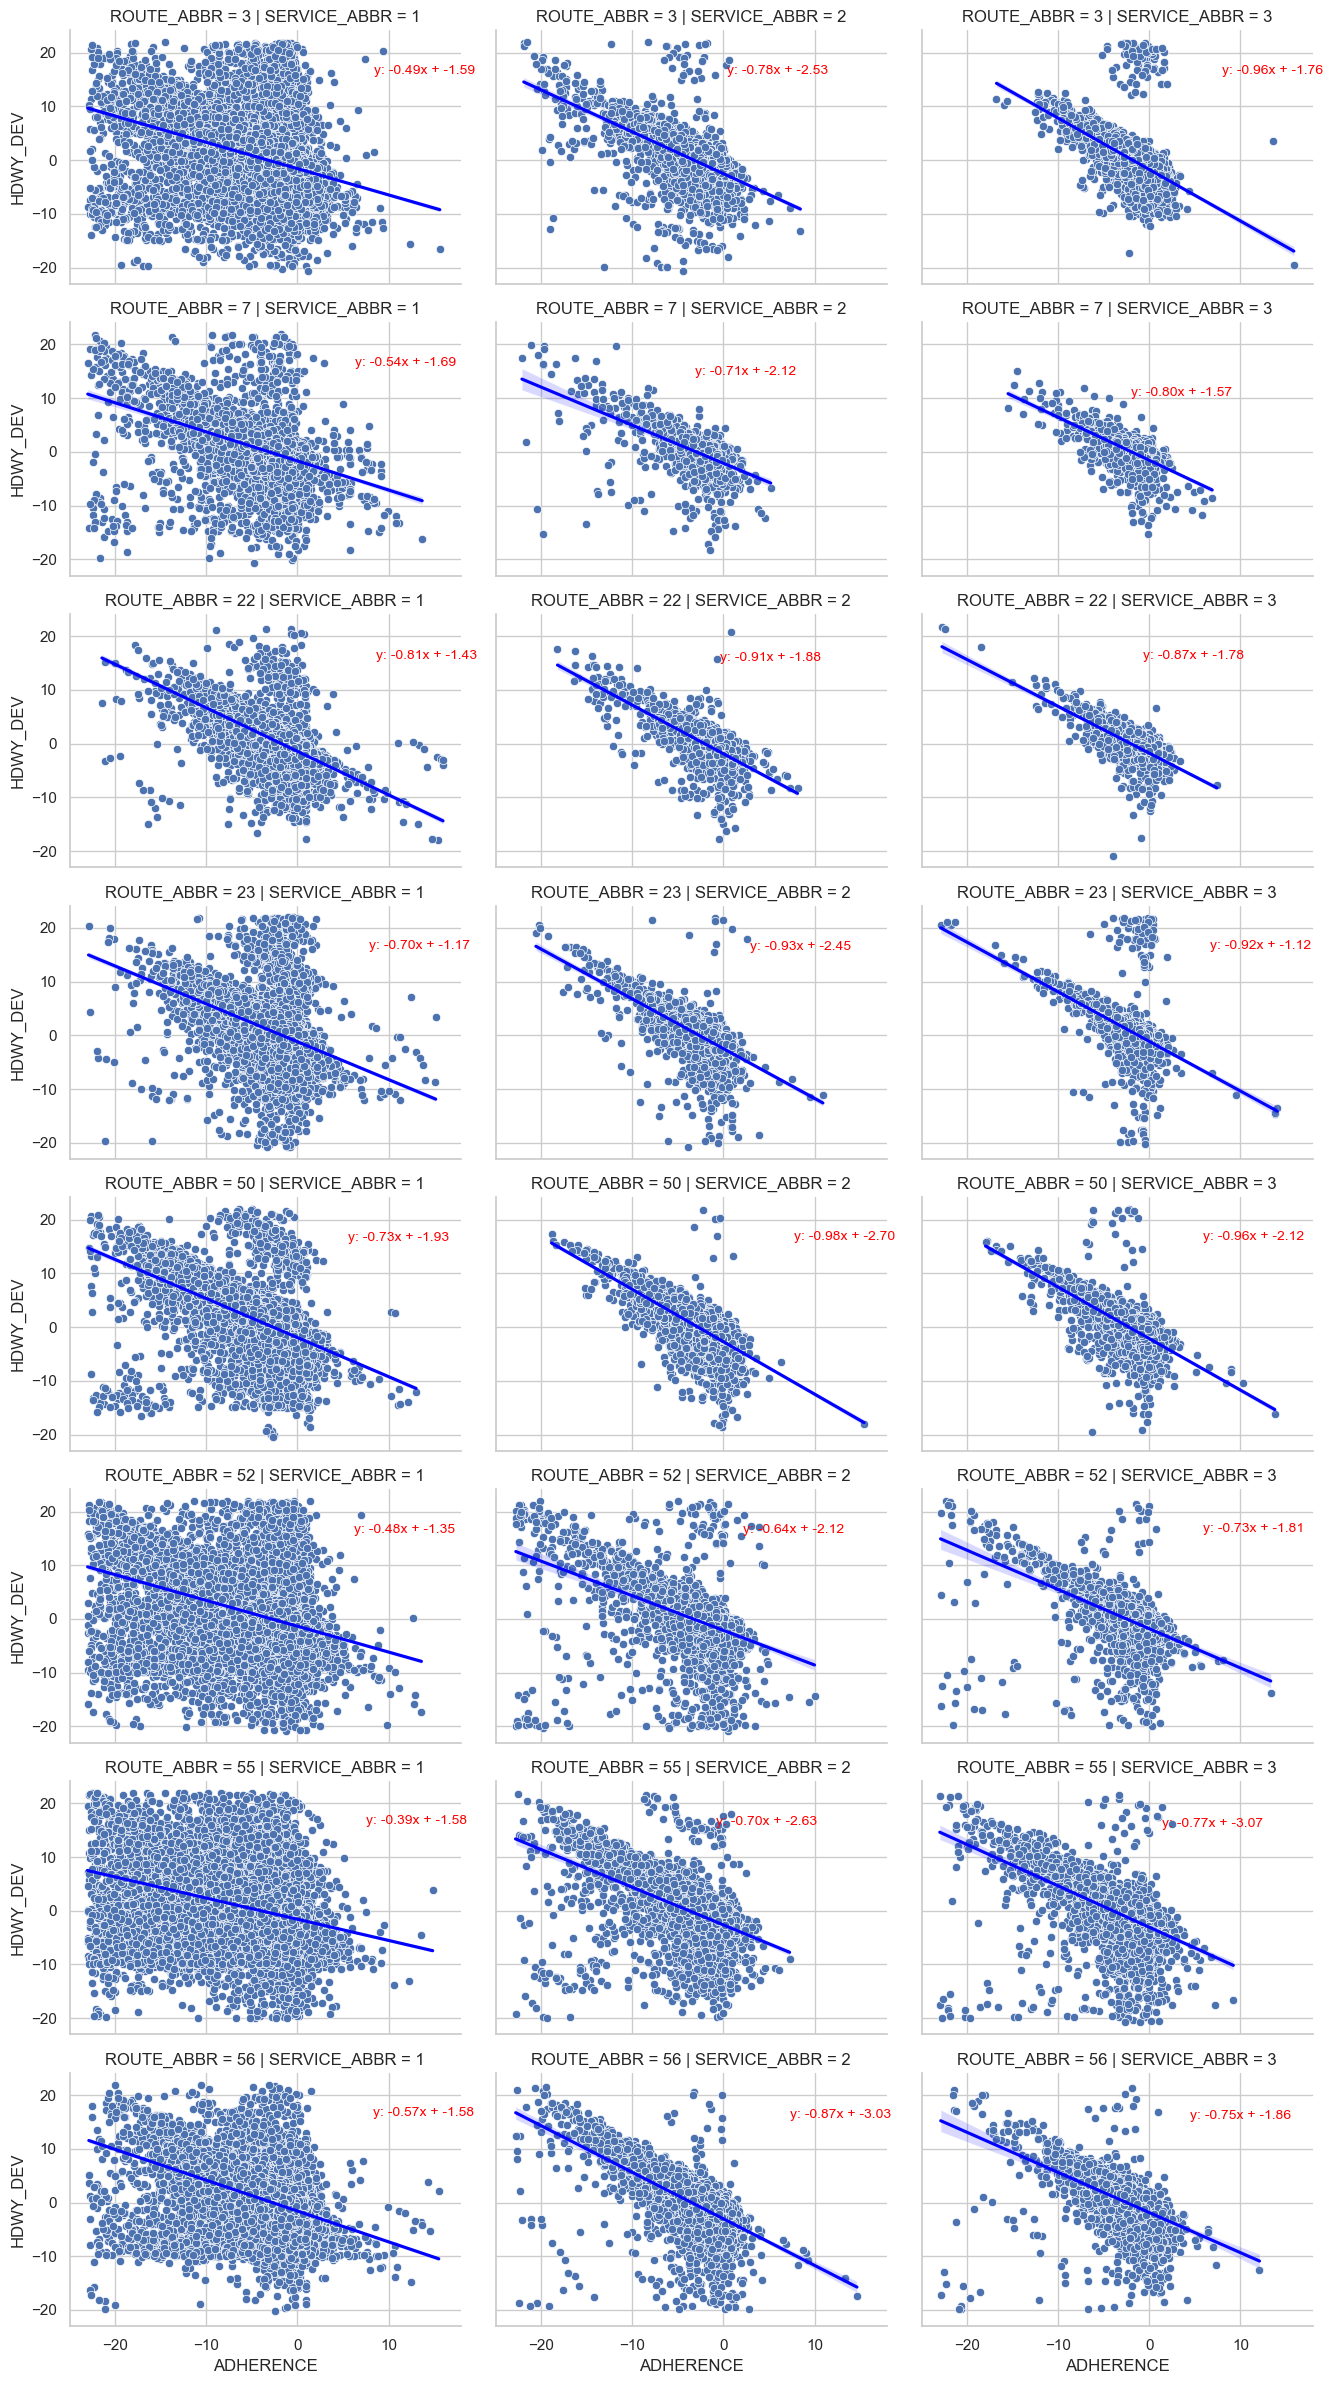

In [53]:
df=data[["ADHERENCE", "SCHEDULED_HDWY", "HDWY_DEV", 'day_name', "ROUTE_ABBR", "ROUTE_DIRECTION_NAME", "SERVICE_ABBR"]].dropna()
# df=df[df["ROUTE_ABBR"].isin([23,50])]
xvar = df["ADHERENCE"]
yvar = df["HDWY_DEV"]
num_std = 3
xmin = np.mean(xvar) - num_std*np.std(xvar)
xmax = np.mean(xvar) + num_std*np.std(xvar)
ymin = np.mean(yvar) - num_std*np.std(yvar)
ymax = np.mean(yvar) + num_std*np.std(yvar)
df = df[(df["ADHERENCE"]>= xmin) & (df["ADHERENCE"]<= xmax) & (df["HDWY_DEV"]>= ymin) & (df["HDWY_DEV"]<= ymax)]
# sns.relplot(data = df, x = 'ADHERENCE', y = 'HDWY_DEV', kind = 'scatter', col = 'SERVICE_ABBR', row = 'ROUTE_ABBR')
g = sns.relplot(data=df, x='ADHERENCE', y='HDWY_DEV', kind='scatter', col='SERVICE_ABBR', row='ROUTE_ABBR', height=3, aspect=1.5)
g.map(sns.regplot, 'ADHERENCE', 'HDWY_DEV', scatter=False, color='blue')  # scatter=False removes duplicate scatter plots

# Add regression coefficients to each plot
for ax, (route, service) in zip(g.axes.flat, df.groupby(['ROUTE_ABBR', 'SERVICE_ABBR'])):
    x_values = service['ADHERENCE']
    y_values = service['HDWY_DEV']
    m, b = np.polyfit(x_values, y_values, 1)
    
    # Display regression coefficients in the top right corner
    text_content = f"y: {m:.2f}x + {b:.2f}"
    textbox_x = np.max(x_values) + 0.1 * (np.max(x_values) - np.min(x_values))
    textbox_y = np.max(y_values) - 0.1 * (np.max(y_values) - np.min(y_values))
    
    ax.text(textbox_x, textbox_y, text_content, fontsize=10, color='red', ha='right', va='top')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()



# Dwell time vs Headway
### We plot the dwell time at the start of the trip against the headway at the end of the trip
### we ignore trips with less than two stops 
- Create a new dataframe with the following columns ['Start_index', 'End_index', 'DWELL_IN_MINS', 'HDWY_DEV', 'stops',
       'ROUTE_ABBR', 'DEPARTURE_TIME', 'ARRIVAL_TIME', 'TRIP_DURATION']
- limit HDWY_DEV and DWELL_IN_MINS to 3 standard deviations each
- plot HDWY_DEV and DWELL_IN_MINS by number of stops and routes


In [25]:
trip_start_indexes = data_complete_trips[data_complete_trips['TRIP_EDGE'] == 1].index.to_list()
trip_end_indexes = data_complete_trips[data_complete_trips['TRIP_EDGE'] == 2].index.to_list()
trip_data = []
for start, end in zip(trip_start_indexes, trip_end_indexes):
    dwell = data_complete_trips.loc[start]["DWELL_IN_MINS"]
    hdwy = data_complete_trips.loc[end-1]["HDWY_DEV"]
    route_abbr = data_complete_trips.loc[start]["ROUTE_ABBR"]
    service_abbr = data_complete_trips.loc[start]["SERVICE_ABBR"]
    departure_time = data_complete_trips.loc[start]["ACTUAL_DEPARTURE_TIME"]
    arrival_time = data_complete_trips.loc[end-1]["ACTUAL_ARRIVAL_TIME"]
    duration = time_difference_in_minutes(arrival_time, departure_time)
    day_name = data_complete_trips.loc[start]["day_name"]
    if not math.isnan(dwell*hdwy) and dwell>=0 and end>start+1 and duration and duration>0:
        trip_data.append({"Start_index": start, 
                          "End_index": end-1, 
                          "DWELL_IN_MINS": dwell, 
                          "HDWY_DEV": hdwy, 
                          "stops": end-start, 
                          "ROUTE_ABBR": route_abbr, 
                          "SERVICE_ABBR": service_abbr,
                          "DEPARTURE_TIME": departure_time,
                          "ARRIVAL_TIME":arrival_time,
                          "TRIP_DURATION":duration,
                          "day_name":day_name
                          })

trip_data = pd.DataFrame(trip_data)
# trip_data.to_csv('../data/trip_data.csv')


In [26]:
# limit HDWY_DEV and DWELL_IN_MINS to 3 standard deviations each and add rounded Dwell_IN_MINS
trip_data = pd.read_csv("../data/trip_data.csv")
df = trip_data
xvar = df["DWELL_IN_MINS"]
yvar = df["HDWY_DEV"]
num_std = 3
xmin = np.mean(xvar) - num_std*np.std(xvar)
xmax = np.mean(xvar) + num_std*np.std(xvar)
ymin = np.mean(yvar) - num_std*np.std(yvar)
ymax = np.mean(yvar) + num_std*np.std(yvar)
df =  df[(df["DWELL_IN_MINS"]>=xmin) & (df["DWELL_IN_MINS"]<xmax) & (df["HDWY_DEV"]>=ymin) & (df["HDWY_DEV"]<ymax)]
df = df.copy()
df["DWELL_IN_MINS_rounded"] = df["DWELL_IN_MINS"].round()
df["TRIP_DURATION_rounded"] = df["TRIP_DURATION"].round()
trip_data = df

### Mean Headway Deviation by Dwell Time

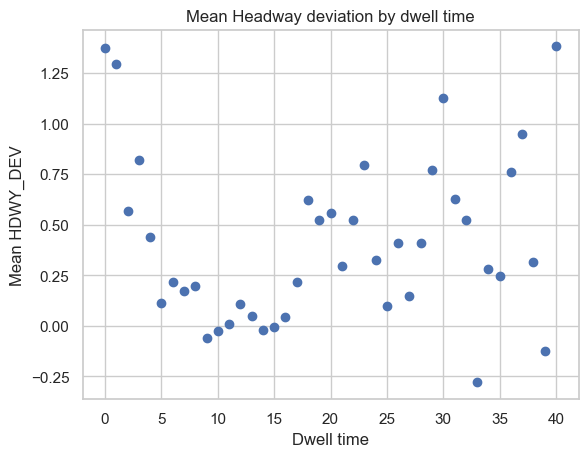

In [27]:
df = trip_data.groupby('DWELL_IN_MINS_rounded')['HDWY_DEV'].mean().reset_index()


# Display the result
plt.scatter(df['DWELL_IN_MINS_rounded'], df['HDWY_DEV'])

# # Set the x-axis range from 2 to 6 with intervals of 1
# plt.xticks(range(2, 7, 1))

plt.xlabel('Dwell time')
plt.ylabel('Mean HDWY_DEV')
plt.title('Mean Headway deviation by dwell time')

plt.show()

### Variability of Headway Deviation with Dwell Time

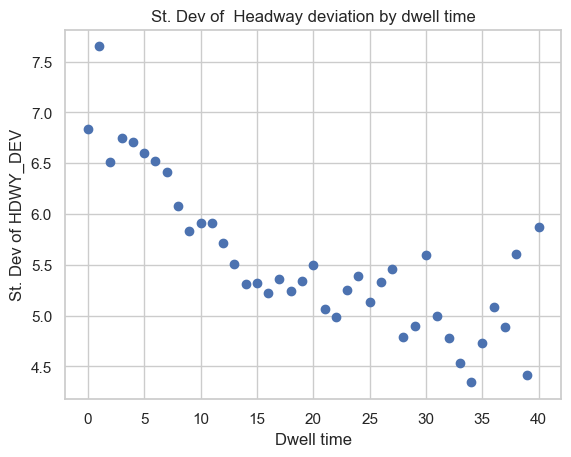

In [28]:
df = trip_data.groupby('DWELL_IN_MINS_rounded')['HDWY_DEV'].std().reset_index()


# Display the result
plt.scatter(df['DWELL_IN_MINS_rounded'], df['HDWY_DEV'])

# # Set the x-axis range from 2 to 6 with intervals of 1
# plt.xticks(range(2, 7, 1))

plt.xlabel('Dwell time')
plt.ylabel('St. Dev of HDWY_DEV')
plt.title('St. Dev of  Headway deviation by dwell time')

plt.show()

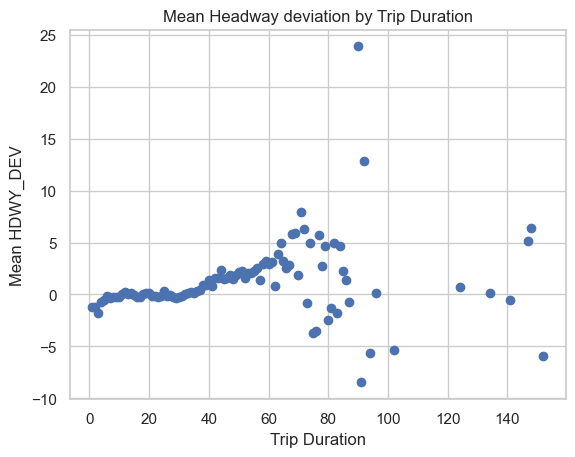

In [29]:
df = trip_data.groupby('TRIP_DURATION_rounded')['HDWY_DEV'].mean().reset_index()


# Display the result
plt.scatter(df['TRIP_DURATION_rounded'], df['HDWY_DEV'])

# # Set the x-axis range from 2 to 6 with intervals of 1
# plt.xticks(range(2, 7, 1))

plt.xlabel('Trip Duration')
plt.ylabel('Mean HDWY_DEV')
plt.title('Mean Headway deviation by Trip Duration')

plt.show()

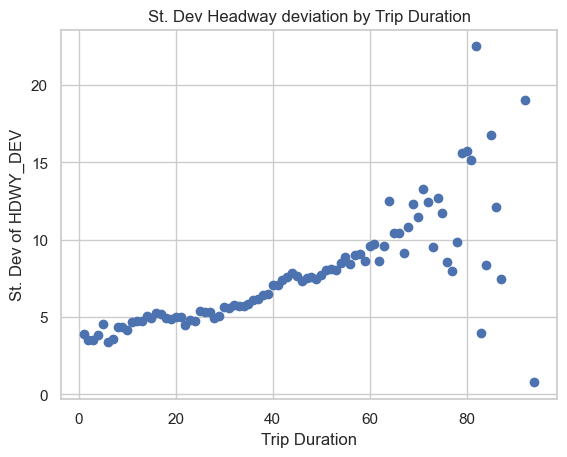

In [30]:
df = trip_data.groupby('TRIP_DURATION_rounded')['HDWY_DEV'].std().reset_index()


# Display the result
plt.scatter(df['TRIP_DURATION_rounded'], df['HDWY_DEV'])

# # Set the x-axis range from 2 to 6 with intervals of 1
# plt.xticks(range(2, 7, 1))

plt.xlabel('Trip Duration')
plt.ylabel('St. Dev of HDWY_DEV')
plt.title('St. Dev Headway deviation by Trip Duration')

plt.show()

In [31]:
sns.set(style="whitegrid")

# Create a FacetGrid with scatter plots
g = sns.FacetGrid(df, col="stops", hue="stops", col_wrap=3)
g.map(sns.scatterplot, "DWELL_IN_MINS", "HDWY_DEV")

# Set labels and title
g.set_axis_labels("DWELL_IN_MINS", "HDWY_DEV")
g.set_titles("Stops: {col_name}")


# Add an overall title to the FacetGrid
g.fig.suptitle("Scatter Plots of DWELL_IN_MINS vs. HDWY_DEV by Number of Stops", y=1.05)

# Show the plot
g.add_legend(title="Stops", loc="upper right")
plt.show()

KeyError: 'stops'

In [ ]:
sns.set(style="whitegrid")

# Create a FacetGrid with scatter plots
g = sns.FacetGrid(df, col="ROUTE_ABBR", hue="ROUTE_ABBR", col_wrap=3)
g.map(sns.scatterplot, "DWELL_IN_MINS", "HDWY_DEV")

# Set labels and title
g.set_axis_labels("DWELL_IN_MINS", "HDWY_DEV")
g.set_titles("Route: {col_name}")
# Add an overall title to the FacetGrid
g.fig.suptitle("Scatter Plots of DWELL_IN_MINS vs. HDWY_DEV by Route", y=1.05)

# Show the plot
g.add_legend(title="Routes", loc="upper right")
plt.show()

In [ ]:
sns.set(style="whitegrid")

# Create a FacetGrid with scatter plots
g = sns.FacetGrid(df, col="ROUTE_ABBR", hue="ROUTE_ABBR", col_wrap=3)
g.map(sns.scatterplot, "TRIP_DURATION", "HDWY_DEV")

# Set labels and title
g.set_axis_labels("TRIP_DURATION (mins)", "HDWY_DEV (mins)")
g.set_titles("Route: {col_name}")

# Add an overall title to the FacetGrid
g.fig.suptitle("Scatter Plots of TRIP DURATION vs. HDWY_DEV by Route", y=1.05)

# Show the plot
g.add_legend(title="Routes", loc="upper right")
plt.show()

In [ ]:
sns.set(style="whitegrid")

# Create a FacetGrid with scatter plots
g = sns.FacetGrid(df, col="day_name", hue="day_name", col_wrap=3)
g.map(sns.scatterplot, "TRIP_DURATION", "HDWY_DEV")

# Set labels and title
g.set_axis_labels("TRIP_DURATION", "HDWY_DEV")
g.set_titles("{col_name}")

# Add an overall title to the FacetGrid
g.fig.suptitle("Scatter Plots of TRIP Duration vs. HDWY_DEV by Day", y=1.05)
# Show the plot
# g.add_legend(title="Days", loc="upper right")
plt.show()

In [ ]:

mean_hdw_dev_by_stop = df.groupby('stops')['HDWY_DEV'].mean()
mean_hdw_dev_by_stop_df = mean_hdw_dev_by_stop.reset_index()

# Display the result
plt.scatter(mean_hdw_dev_by_stop_df['stops'], mean_hdw_dev_by_stop_df['HDWY_DEV'])

# Set the x-axis range from 2 to 6 with intervals of 1
plt.xticks(range(2, 7, 1))
plt.xlabel('Stops')
plt.ylabel('Mean of HDWY_DEV')
plt.title('Mean of HDWY_DEV by number of stops')

plt.show()


In [ ]:
# Assuming your DataFrame is named 'df'
std_hdw_dev_by_stop = df.groupby('stops')['HDWY_DEV'].std()

# If you want the result as a DataFrame
std_hdw_dev_by_stop_df = std_hdw_dev_by_stop.reset_index()


# Display the result
plt.scatter(std_hdw_dev_by_stop_df['stops'], std_hdw_dev_by_stop_df['HDWY_DEV'])

# Set the x-axis range from 2 to 6 with intervals of 1
plt.xticks(range(2, 7, 1))

plt.xlabel('Stops')
plt.ylabel('Standard Deviation of HDWY_DEV')
plt.title('Standard Deviation of HDWY_DEV by number of stops')

plt.show()


In [ ]:
df.head()

In [ ]:
df["DWELL_IN_MINS_rounded"] = df.copy()["DWELL_IN_MINS"].round()

In [ ]:
df.head()

In [ ]:
u = df.groupby('DWELL_IN_MINS_rounded')['HDWY_DEV'].std().reset_index()


# Display the result
plt.scatter(u['DWELL_IN_MINS_rounded'], u['HDWY_DEV'])

# # Set the x-axis range from 2 to 6 with intervals of 1
# plt.xticks(range(2, 7, 1))

plt.xlabel('Dwell time')
plt.ylabel('Std HDWY_DEV')
plt.title('Std Headway deviation by dwell time')

plt.show()

In [ ]:
u = df.groupby('DWELL_IN_MINS_rounded')['HDWY_DEV'].mean().reset_index()


# Display the result
plt.scatter(u['DWELL_IN_MINS_rounded'], u['HDWY_DEV'])

# # Set the x-axis range from 2 to 6 with intervals of 1
# plt.xticks(range(2, 7, 1))

plt.xlabel('Dwell time')
plt.ylabel('Mean HDWY_DEV')
plt.title('Mean Headway deviation by dwell time')

plt.show()